# Imports and Configuration

In [1]:
import glob
import os
from joblib import dump, load
import pandas as pd
import numpy as np
import shutil
import seaborn as sn
import matplotlib.pyplot as plt
from skimage import io, color, filters
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
# Dataset images directory
DATASET_IMAGES_PATH = '../dataset-images'

# Grid-based dataset csv file
DATASET_CSV_PATH = '../dataset-numpy/grid_dataset_8.csv'

# Scaler location
SCALER_PATH = '../classifiers/scaler.joblib'

# KNN Classifier location
KNN_CLASSIFIER_PATH = '../classifiers/knn_classifier.joblib'

# The Grid Size used in the dataset
GRID_SIZE = 8

# Temp directory
TEMP_DIR_PATH = '../temp'

# Helper Functions
These functions are all used in the feature extraction state, for more information on their use and how they work, please consult its documentation. 

In [3]:
# Crop an image (size 128x32) into four images (size 32x32)
# Returns an array of four cropped images
def crop_image(image):
  crops = []
  for i in range(5):
    y1 = 0
    y2 = 32
    x1 = i * 32
    x2 = (i + 1) * 32
    crops.append(image[y1:y2, x1:x2])
  
  return crops

In [4]:
# Transform an image to its binary form
def to_binary(image):
  grey = color.rgb2gray(image)
  thresh = filters.threshold_isodata(grey)
  return grey < thresh

# Get grid based features
def to_grid(binary):
  grids = []
  lg = int(len(binary) / GRID_SIZE)

  for row in range(0, GRID_SIZE):
    row_of_grids = []
    for col in range(0, GRID_SIZE):
      grid = []
      for y in range(lg*row, lg*row + lg):
        for x in range (lg*col, lg*col + lg):
          grid.append(binary[y][x])
      row_of_grids.append(grid)
    grids.append(row_of_grids)
  
  return grids

# Count all positive values in the grid
def count_positive(grid):
  count = []

  for y in range(0, len(grid)):
    for x in range(0, len(grid[y])):
      sum = np.sum(grid[y][x])
      count.append(sum)
  
  return count

# Transform an image into an array of sums of positive
# values in the grids
def image_to_count(image):
  binary = to_binary(image)
  grid = to_grid(binary)
  positive_count = count_positive(grid)
  return positive_count

# Grid Based Model

As no huge improvement over the obtained dataset(s) could be found during our feature analysis, we will train the model with one of the better performing datasets we generated during the feature extraction stage.

We'll be training the model using the features from an 8x8 grid, as these got us the best results with the least amount of data (64 values instead of 256 or 1024 for the bigger grids). We won't be optimizing the data by removing columns, as this yielded no (significant) improvement.

In [5]:
# Import the dataset into a DataFrame
df_grid = pd.read_csv(DATASET_CSV_PATH)

# Describe the dataset to see if it's been loaded in properly
df_grid.describe()

,label,sum_1,sum_2,sum_3,sum_4,sum_5,sum_6,sum_7,sum_8,sum_9,...,sum_55,sum_56,sum_57,sum_58,sum_59,sum_60,sum_61,sum_62,sum_63,sum_64
count,1920.000000,1920.0,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.0,...,1920.000000,1920.000000,1920.0,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,4.532813,0.0,0.314063,5.597396,11.808854,11.475000,5.480729,1.403125,0.135937,0.0,...,3.780208,0.171354,0.0,0.301042,5.942708,11.888021,11.398958,6.768229,2.170313,0.243750
std,2.868122,0.0,0.898618,4.719974,4.291663,4.549238,5.599137,3.396039,0.968907,0.0,...,4.966340,0.847589,0.0,0.963102,4.999828,4.403024,5.040451,5.838359,4.102345,1.316098
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.0,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000
50%,5.000000,0.0,0.000000,5.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.0,...,1.000000,0.000000,0.0,0.000000,5.000000,13.000000,13.000000,7.000000,0.000000,0.000000
75%,7.000000,0.0,0.000000,9.000000,15.000000,15.000000,10.000000,0.000000,0.000000,0.0,...,7.000000,0.000000,0.0,0.000000,10.000000,15.000000,16.000000,12.000000,2.000000,0.000000
max,9.000000,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,12.000000,0.0,...,16.000000,12.000000,0.0,10.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


## KNN Model Creation

We can create a KNN model by removing the labels from our dataframe, scaling our data using a MinMaxScaler and spliting it up into train and test sets. The KNN Classifier will be trained on the train set, which consists of 90% of our total dataset. It will then be tested (scored) using the remaining 10%.

In [6]:
# Get the dataset without the labels from the DataFrame
X = df_grid.drop('label', axis=1)

# Get an array of labels that correspond with the dataset above
Y = df_grid['label']

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the dataset and scale the data
X_scaled = scaler.fit_transform(X)

# Create train and test sets (for both data and labels), with 90% of the data
# being used to train and 10% to test the model
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=.1)

# Create a KNN Classifier with K = 3
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier on the training set
knn_classifier.fit(X_train, Y_train)

# Score the classifier using the built in score function and the test set
# created earlier
score = knn_classifier.score(X_test, Y_test)
percentage = round( score * 100 , 2)

# Print the received score as a percentage
print('score: {}%'.format(percentage))

score: 96.88%


We can export our model (and MinMaxScaler) using the joblib library:

In [7]:
# Export the MinMaxScaler
dump(scaler, SCALER_PATH)

# Export the Model
dump(knn_classifier, KNN_CLASSIFIER_PATH)

['../classifiers/knn_classifier.joblib']

## Cross Validation

Using the K-Fold Cross Validation, one can (accurately) determine if a model is actually accurate or just overfit. This is done by splitting up the dataset into K parts (in this case 10), of which one is used for testing and the rest for training. 

The cross_val_score trains the KNN model ten times, each of which a different group (out of the ten) is used for testing. This means that a different test set is used every time and that the test set is 10% of the whole dataset.

In [8]:
# Create a new KNN Classifier for cross validation with K = 3
knn_cv = KNeighborsClassifier(n_neighbors=3)

# Train model with a cross validation value of 10
cv_scores = cross_val_score(knn_cv, X_scaled, Y, cv=10)

# Calculate the average score
avg = cv_scores.sum() / 10
percentage = round(avg * 100, 2)
print('average score: {0}%'.format(percentage))

average score: 98.07%


## Classifier Evaluation

In [9]:
# Load the preprocessor
preproc = load(SCALER_PATH) 

# Load your final classifier
clf = load(KNN_CLASSIFIER_PATH) 

In [10]:
  """
  Load an image from file and predict the four digits in the image.
  The result should be an array containing the 4 digits (as string)
  """
def classify_image(filename):
    result = list()
        
    # Load the image from file
    img_array = io.imread(filename)
    crops = crop_image(img_array)

    # For each digit, collect features, preprocess and predict
    for i in range(4):
      image_crop = crops[i]

      X = image_to_count(image_crop)
      X_scaled = preproc.transform([X])

      Y = clf.predict(X_scaled)
      result.append(str(Y[0]))
            
    return result

In [11]:
# Outcomes
correct_classified_digits = 0
incorrect_classified_digits = 0
correct_classified_zipcodes = 0
incorrect_classified_zipcodes = 0

# Score the classifier
files = glob.glob(os.path.join(DATASET_IMAGES_PATH, '*.png'))
for f in files:
    # Get the correct label from the filename
    correct_label = f[-8:-4]
    # Predict using the classifier
    predicted_label = classify_image(f)
    
    # Score digits
    zipcode_correct = True
    for i in range(len(correct_label)):
        if str(correct_label[i]) == str(predicted_label[i]):
            correct_classified_digits += 1
        else:
            incorrect_classified_digits += 1
            zipcode_correct = False
    
    # Score correct zipcodes
    if zipcode_correct:
        correct_classified_zipcodes += 1
    else:
        incorrect_classified_zipcodes += 1

print("Digit accuracy: ", (correct_classified_digits / (correct_classified_digits + incorrect_classified_digits)), "(", correct_classified_digits, "/", incorrect_classified_digits, ")")
print("Zipcode accuracy: ", (correct_classified_zipcodes / (correct_classified_zipcodes + incorrect_classified_zipcodes)), "(", correct_classified_zipcodes, "/", incorrect_classified_zipcodes, ")")        


Digit accuracy:  0.9875 ( 1896 / 24 )
Zipcode accuracy:  0.95 ( 456 / 24 )


Observed accuracies:


| Grid size:                      | 1x1 | 2x2 | 4x4 |
|---------------------------------|-----|-----|-----|
| Digit Accuracy / Zipcode Accuracy | 0.15677083333333333 / 0.0 | 0.734375 / 0.3104166666666667 | 0.9770833333333333 / 0.9166666666666666 |
| Digit Accuracy / Zipcode Accuracy | 0.16458333333333333 / 0.0 | 0.728125 / 0.28541666666666665 | 0.9755208333333333 / 0.9104166666666667 |
| Digit Accuracy / Zipcode Accuracy | 0.1640625 / 0.0020833333333333333 | 0.7338541666666667 / 0.3125 | 0.9765625 / 0.9125 |
| AVERAGE / AVERAGE | 16.18% / 0.00% | 73.21% / 30.28% | 97.64% / 91.32% |

| Grid size: | 8x8 | 16x16 | 32x32 |
|-----|-----|-----|-----|
| Digit Accuracy / Zipcode Accuracy | 0.9880208333333333 / 0.9520833333333333 | 0.9890625 / 0.95625 | 0.9822916666666667 / 0.9291666666666667 |
| Digit Accuracy / Zipcode Accuracy | 0.9895833333333334 / 0.9583333333333334 | 0.9869791666666666 / 0.9479166666666666 | 0.9848958333333333 / 0.9395833333333333 |
| Digit Accuracy / Zipcode Accuracy | 0.9895833333333334 / 0.9583333333333334 | 0.9869791666666666 / 0.95 | 0.9838541666666667 / 0.9354166666666667 |
| AVERAGE / AVERAGE | 98.91% / 95.63% | 98.77% / 95.14% | 98.37% / 93.47% |


# Image based model

Author: Dovydas Valiulis 436254

Finally, we trained our classifiers to see what scores we can get. During this phase we looked at five classifiers:
1. KNeighborsClassifier (n nearest neighbors)
2. GaussianNB (gaussian naive bias)
3. SVC (Support Vector Machines)
4. DecisionTreeClassifier
5. RandomForestClassifier

Also, we fitted two more classifiers. First, we fitted AdaBoostClassifier using our best fit classifier out of the first five to see if we can improve results and then we fitted QuadraticDiscriminantAnalysis to see what score could it reach.

## Loading data

Before any of that, we loaded our data that was made in the previous phases. First, we loaded labels because they are the same for all datasets. Then we have 3 different datasets. 
1.  Manually selected feature dataset
2. Automatically selected feature dataset using chi2 algorithm
3. Automatically selected feature dataset using the f-classif algorithm

We provide results of each dataset in future sections. 

In [12]:
# loading labels of the data set
labels = load(TEMP_DIR_PATH + '/datasets/label-dataset.pkl')

**To load the dataset execute one of the following three code cells.**

Load manual feature

In [13]:
# Loading data from manualy selected features
X = load(TEMP_DIR_PATH + '/datasets/manualy-selected-feature-dataset.pkl')

Load auto features (chi2) 

In [14]:
# Loading data from automatically selected features
X = load(TEMP_DIR_PATH + '/datasets/auto-selected-features-chi2.pkl')

Load auto features (f-classif)

In [15]:
# Loading data from automatically selected features
X = load(TEMP_DIR_PATH + '/datasets/auto-selected-features-f-classif.pkl')

## Split data into train and validation sets


To avoid overfitting our classifiers we decided to split our data into training and validation datasets. The training dataset is 90% of the whole dataset and the validation dataset is 10%. to assure that our training and validation datasets are always the same we specify random_state seed as 20.

In [16]:
# Spliting data and labels into validation and training sets
X_train, X_validate, y_train, y_validate = train_test_split(X, labels, test_size=0.10, random_state=20)

## Train
To find the best hyperparameters for a specific classifier we are using the GridSearchCV module from sklearn. As already mentioned we tested five classification algorithms with each dataset and gathered their score for comparison.

### KNeighborsClassifier

In [17]:
parameters = {'n_neighbors': range(1,10), \
            'weights': ['uniform', 'distance'], \
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], \
            'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

clf = KNeighborsClassifier()
gs_clf = GridSearchCV(clf, parameters, cv=5, iid=False)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_estimator_)
print(gs_clf.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
0.8841396708091389


**GridSearchCV Results**

| Dataset         | n_neighbors | weights | algorithm | metric  | score |
|-----------------|-------------|---------|-----------|---------|-------|
| Manual          |     5       |distance |  auto     |euclidean| 88.41%|
| Auto chi2       |     5       |distance |  auto     |euclidean| 88.41%|
| Auto f-classif  |     5       |distance |  auto     |euclidean| 88.41%|

### Gaussian naive bias

In [18]:
parameters = {}

clf = GaussianNB()
gs_clf = GridSearchCV(clf, parameters, cv=5, iid=False)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_estimator_)
print(gs_clf.best_score_)

GaussianNB(priors=None, var_smoothing=1e-09)
0.8315250970404511


**GridSearchCV Results**

| Dataset         | score |
|-----------------|-------|
| Manual          |83.15% |
| Auto chi2       |83.15% |
| Auto f-classif  |83.15% |

### Support Vector Machines

In [19]:
parameters = {'C': [0.1, 1, 10, 100, 1000], \
            'kernel': ['linear', 'rbf', 'poly'], \
            'gamma': [0.1, 1, 10, 100], \
            'degree': [0, 1, 2, 3, 4, 5, 6]}

clf = SVC()
gs_clf = GridSearchCV(clf, parameters, cv=5, iid=False)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_estimator_)
print(gs_clf.best_score_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.9246436645992289


**GridSearchCV Results**

| Dataset         | C           | kernel  | gamma     | degree | score |
|-----------------|-------------|---------|-----------|--------|-------|
| Manual          |   1         |  poly   |   1       |    3   | 92.46%|
| Auto chi2       |   1         |  poly   |   1       |    3   | 92.46%|
| Auto f-classif  |   1         |  poly   |   1       |    3   | 92.46%|

### DecisionTreeClassifier

In [20]:
parameters = {'criterion': ['gini', 'entropy'], \
            'splitter': ['best', 'random'], \
            'max_depth': range(1,10)}

clf = DecisionTreeClassifier()
gs_clf = GridSearchCV(clf, parameters, cv=5, iid=False)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_estimator_)
print(gs_clf.best_score_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.8384800682562711


**GridSearchCV Results**

| Dataset         | criterion   | splitter| max_depth | score |
|-----------------|-------------|---------|-----------|-------|
| Manual          |   gini      |  best   |      9    | 83.78%|
| Auto chi2       |   gini      |  best   |      7    | 83.68%|
| Auto f-classif  |   gini      |  best   |      8    | 83.78%|

### RandomForestClassifier

In [21]:
parameters = {'criterion': ['gini', 'entropy'], \
            'n_estimators': [1, 10, 100, 200, 300], \
            'max_depth': range(1,10)}

clf = RandomForestClassifier()
gs_clf = GridSearchCV(clf, parameters, cv=5, iid=False)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_estimator_)
print(gs_clf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.9039269867737056


**GridSearchCV Results**

| Dataset         | criterion   | n_estimators | max_depth | score |
|-----------------|-------------|--------------|-----------|-------|
| Manual          |  entropy    |   200        |      9    | 90.10%|
| Auto chi2       |  entropy    |   200        |      9    | 90.39%|
| Auto f-classif  |  entropy    |   200        |      9    | 90.16%|

## Best classifier 

From our experiments, we determined that the best classifier based on image features is SVC (Support Vector Machines). It scored 92.46% percent accuracy through all datasets. 

In [22]:
# selecting best clasifier
best_clf = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, \
                    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly', \
                    max_iter=-1, probability=False, random_state=None, shrinking=True, \
                    tol=0.001, verbose=False)


## Bonus classifier experiments

In [23]:
# Training and scoring Ada Boost Classifier algorithm
kf = KFold(n_splits=3, shuffle=True)
for train_index, test_index in kf.split(X_train):
    X_k_train, X_k_test = X_train[train_index], X_train[test_index]
    y_k_train, y_k_test = y_train[train_index], y_train[test_index]
    
    clf = AdaBoostClassifier(base_estimator=best_clf, random_state = 20, algorithm='SAMME')
    clf.fit(X_k_train, y_k_train)
    print(clf.score(X_k_test, y_k_test))

0.7517361111111112
0.7413194444444444
0.7739130434782608


| Dataset         | run 1   | run 2  | run 3  |
|-----------------|---------|--------|--------|
| Manual          | 68.75%  | 69.44% | 71.47% |
| Auto chi2       | 66.49%  | 63.02% | 70.26% |
| Auto f-classif  | 69.96%  | 73.09% | 72%    |

In [24]:
# Training and scoring Quadratic Discriminant Analysis algorithm
kf = KFold(n_splits=3, shuffle=True)
for train_index, test_index in kf.split(X_train):
    X_k_train, X_k_test = X_train[train_index], X_train[test_index]
    y_k_train, y_k_test = y_train[train_index], y_train[test_index]
    
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_k_train, y_k_train)
    print(clf.score(X_k_test, y_k_test))

0.7413194444444444
0.8263888888888888
0.8156521739130435


C:\Users\Dovydas\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dovydas\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dovydas\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


| Dataset         | run 1   | run 2  | run 3  |
|-----------------|---------|--------|--------|
| Manual          | 80.38%  | 85.93% | 81.04% |
| Auto chi2       | 87.67%  | 80.20% | 80.52% |
| Auto f-classif  | 78.99%  | 77.08% | 84.52% |

## Results

Different feature selection methods appeared not to have any meaningful effect on classification scoring. Most of the scores of the same algorithm with different datasets were the same. The exception was RandomForestClassifier where results were between 90.10% and 90.39%. 

We haven't anticipated this result beforehand. we hypothesized that different feature selection methods would yield different classification results. We didn't see that. On further investigation, we suspect that either we selected the same features manually as automatic algorithms or that there are too few features to differentiate between different selection methods. Experiments with different feature numbers in automatic feature selection might yield different results.

Out of our five tested classifiers consistently the best was SVC (Support Vector Machines). It scored over 92% with all datasets. All classifier list from best to last :
1. SVC - 92.46%
2. RandomForestClassifier - 90.39%
3. KNeighborsClassifier - 88.41%
4. DecisionTreeClassifier - 83.78%
5. Gaussian naive bias - 83.15%

In [25]:
# Validating best clasifier
best_clf.fit(X_train, y_train)
score = best_clf.score(X_validate, y_validate)
print("validation score: {}%".format(score*100))

validation score: 90.625%


Our best classification algorithm yielded validation score of : 96.88%

In [26]:
predicted = best_clf.predict(X_validate)
print(classification_report(y_validate, predicted))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       1.00      0.95      0.98        21
           2       0.81      0.93      0.87        14
           3       0.79      0.86      0.83        22
           4       0.95      0.95      0.95        20
           5       0.90      0.82      0.86        22
           6       0.94      0.94      0.94        18
           7       0.84      0.94      0.89        17
           8       1.00      0.84      0.91        19
           9       0.90      0.90      0.90        21

    accuracy                           0.91       192
   macro avg       0.91      0.91      0.91       192
weighted avg       0.91      0.91      0.91       192



(10.0, 0.0)

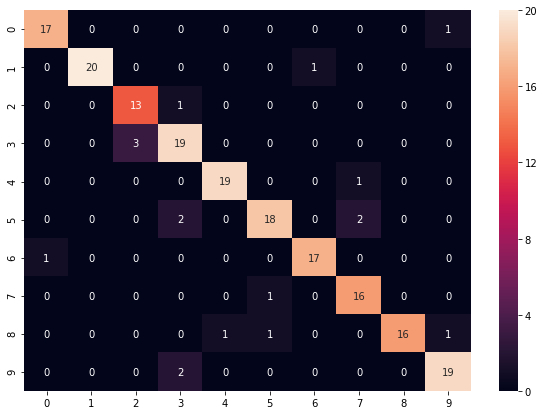

In [27]:
cf = confusion_matrix(y_validate, predicted)

df_cm = pd.DataFrame(cf, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

From the confusion matrix, we can see that six out of ten numbers are classified with a 100% accuracy. In this plot, we can see that the most difficult numbers to classify for this solution are 0, 4, 5, 9. All these numbers share some features of each other. For instance, 4 and 9 have one hole and have a trail in the bottom part of the number. From the Confusion matrix, we also can see that 9 was the hardest number to predict.

## Exporting Image classifier artifacts

In [28]:
dump(X,'../dataset-numpy/img-f-dataset.pkl')
dump(labels,'../dataset-numpy/img-f-dataset-labels.pkl')

bst_sclr = load(TEMP_DIR_PATH + '/preprocessors/manual-image-feature-preprocessor.pkl')
dump(bst_sclr,'../classifiers/best-img-f-sclr.pkl')

dump(best_clf,'../classifiers/best-img-f-clf.pkl')

['../classifiers/best-img-f-clf.pkl']

# Conclusion

Having done experiments on both image-based and grid-based feature classification we can definitively say that grid-based feature classification is better by around 2% when comparing the best image feature classifier and grid feature classifier. Furthermore, when determining the whole zip code difference of 2 percent in single-digit recognition is exponentially higher. Therefore, a better solution for zip code prediction is grid-based feature classification. 

# Cleanup
Ensure no data is left on the runtime after execution of all code has completed. This ensures we won't re-use old data once something in the code has changed, eliminating the risk of hours of debugging functional code.

In [29]:
# # Remove all data from the /content directory
# if os.path.isdir(DATASET_IMAGES_PATH):
#   shutil.rmtree(DATASET_IMAGES_PATH)

# if os.path.isfile(DATASET_CSV_PATH):
#   os.remove(DATASET_CSV_PATH)

# if os.path.isfile(KNN_CLASSIFIER_PATH):
#   os.remove(KNN_CLASSIFIER_PATH)

# if os.path.isfile(SCALER_PATH):
#   os.remove(SCALER_PATH)